<a href="https://colab.research.google.com/github/omkardpatil/conformal_cooling_channels_design_optimization/blob/main/GA_QC_FE_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
import fenics
clear_output()

In [ ]:
def work(mesh, u, temp_threshold_for_fitness):
  # Define your mesh and function space
  V = FunctionSpace ( mesh, "Lagrange", 1 )

  # Create a function to interpolate 'u' to the function space
  u_interpolated = interpolate(u, V)

  # Get the values of 'u' at all nodes
  u_values = u_interpolated.vector().get_local()
  np_u = np.array(u_values)
  # Use np.ceil to round up each element to the nearest integer
  integer_array = np.ceil(np_u).astype(int)
  unique_elements, counts = np.unique(integer_array, return_counts=True)
  element_count_dict = dict(zip(unique_elements, counts))
  fitness=0
  for i, j in element_count_dict.items():
      r=i-temp_threshold_for_fitness
      if(r>0):
          fitness+=(j*j*r)
  return fitness

In [ ]:
def generate_mesh_here(circle, mesh_res):
  circle_x,circle_y,circle_r = circle
  domain = Circle(Point(0.0,0.0),1.0) -Rectangle(Point(-2.0,-2.0), Point(2.0,0.0))-Rectangle(Point(-2.0,0.0), Point(0.0,2.0))\
          - Circle(Point(circle_x,circle_y),circle_r)
  mesh = generate_mesh ( domain, mesh_res )
  return mesh

In [ ]:
from fenics import *
from mshr import *
from math import *
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm



T_hot_edge = 150
T_cold_circle = 20
T_body_init = 40
point = (0.4,0.1)
threshold_dis = 0.02
temp_threshold_for_fitness=25
temp_threshold_for_stopping=35
mesh_res=20
t0=0.3 #time for which hot plastic will be in contact
#  Define time things
t_init = 0.0
t_final = 2.0
t_num = 20

u_origin=[]

def heat_implicit (circle):
  mesh  = generate_mesh_here(circle, mesh_res)

  V = FunctionSpace ( mesh, "Lagrange", 1 )

  rect_u = T_hot_edge #150.0
  def outer_circle_on ( x, on_boundary ):
    return 1-(x[0]**2+x[1]**2)<threshold_dis #x[0]+x[1]>1

  rect_bc = DirichletBC ( V, rect_u, outer_circle_on )

  circle_u = T_cold_circle#20.0
  def inner_circle_on ( x, on_boundary ):
    r = sqrt ( ( x[0] - circle_x ) ** 2 + ( x[1] - circle_y ) ** 2 )
    return abs(circle_r-r)< threshold_dis

  circle_bc = DirichletBC ( V, circle_u, inner_circle_on )
  bc = [ rect_bc, circle_bc ]
  bc_new = [circle_bc]

#  Define the trial functions (u) and test functions (v).
  u = TrialFunction ( V )
  v = TestFunction ( V )


#  The diffusivity is a constant.
  k = Constant ( 1.0 )
#  The source term is zero.
  f = Constant ( 0.0 )
  dt = ( t_final - t_init ) / t_num

#  Create U_INIT.
  u_init = Expression ( str(T_body_init), degree = 10 )
  u_old = interpolate ( u_init, V )
  fvt = ( u_old + dt * f ) * v * dx
  Auvt = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
  u = Function ( V )
  t = t_init

  v_min=20
  v_max=100
  for j in range ( 0, t_num + 1):
    t = t + dt
    if(t>t0):
      bc=bc_new
    solve ( Auvt == fvt, u, bc )
    u_old.assign ( u )
    max_value= u.vector().max()
    if(max_value<temp_threshold_for_stopping):
      fitness1 = work(mesh, u, temp_threshold_for_fitness)
      fitness2 = exp(3)
      return fitness1*fitness2
  fitness1 = work(mesh, u, temp_threshold_for_fitness)
  fitness2 = exp(3)
  return fitness1*fitness2

def heat_implicit_test (circle):
  level = 30
  set_log_level ( level )
  return heat_implicit(circle)

In [ ]:
#test
circle_x = 0.4
circle_y = 0.4
circle_r = 0.1
circle = [circle_x,circle_y,circle_r]
ans =heat_implicit_test (circle)
clear_output()
print(ans)

7361128.341442125


In [ ]:
import random
import numpy as np
# Example usage
population_size = 25
generations = 50
mutation_rate = 0.3
max_fitness_list=[]
avg_fitness_list=[]
circles_list = []

def generate_individual():
    x = random.uniform(0.05, 0.95)
    y = random.uniform(0.05, sqrt(1-x**2))
    r_min=0.05
    r_max=min(x, y, sqrt(1-y**2)-x, sqrt(1-x**2)-y)
    r = random.uniform(r_min, r_max)
    return [x, y, r]

def custom_fitness(x, y, r):
    circle = [x,y,r]
    #print(circle)
    ans = heat_implicit_test (circle)
    return  -ans #(x**2 + y**2 + r**2)

def crossover(parent1, parent2):
    child = [random.choice([parent1[i], parent2[i]]) for i in range(3)]
    return child

def mutate(individual, mutation_rate):
    for i in range(3):
        if random.random() < mutation_rate:
            print("^---- Mutation occured in this generation")
            individual[i] += random.uniform(-0.02, 0.02)  # Small random change
            if(i==0):
                individual[i]=np.clip(individual[i], 0.05, 0.95)
            elif(i==1):
                individual[i]=np.clip(individual[i],0.05, sqrt(1-individual[0]**2))
            else:
                x=individual[0]
                y = individual[1]
                r_min=0.05
                r_max=min(x, y, sqrt(1-y**2)-x, sqrt(1-x**2)-y)-0.05
                individual[i]=np.clip(individual[i],r_min,r_max)

    return individual

def genetic_algorithm(population_size, generations, mutation_rate):
    population = [generate_individual() for _ in range(population_size)]
    for generation in range(generations):
        print(generation)
        population = sorted(population, key=lambda ind: custom_fitness(*ind), reverse=True)

        # Print average and maximum fitness for each generation
        avg_fitness = sum(custom_fitness(*ind) for ind in population) / population_size

        max_fitness = custom_fitness(*population[0])
        avg_fitness_list.append(avg_fitness)
        max_fitness_list.append(max_fitness)
        circles_list.append(population[0])

        parents = population[:2]
        child = crossover(parents[0], parents[1])
        child = mutate(child, mutation_rate)

        population[-1] = child

    # Return the fittest individual
    return max(population, key=lambda ind: custom_fitness(*ind))

result = genetic_algorithm(population_size, generations, mutation_rate)
clear_output()
print(result)
print("Optimal Solution:", result)
print("Optimal Fitness:", custom_fitness(*result))

[0.6772696467379433, 0.21543052931344397, 0.10329638007328237]
Optimal Solution: [0.6772696467379433, 0.21543052931344397, 0.10329638007328237]
Optimal Fitness: -1103800.6816137782


##Here on plots of GA fitness

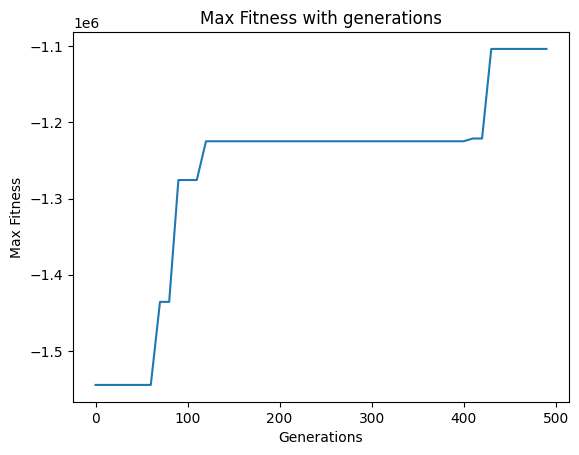

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate y1 and y2 values (replace these with your actual data)
y1 = max_fitness_list

# Generate x values using np.arange
x = np.arange(0, len(y1))
x = [x_ * 10 for x_ in x]

# Plot the data
plt.plot(x, y1, label='y1')  # Line for y1

# Add labels and title
plt.xlabel('Generations')
plt.ylabel('Max Fitness')
plt.title('Max Fitness with generations')

# Show the plot
plt.show()

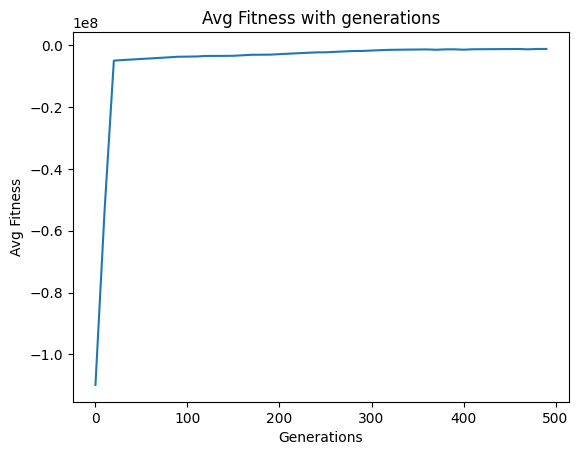

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate y1 and y2 values (replac e these with your actual data)
y1 = avg_fitness_list

# Generate x values using np.arange
x = np.arange(0, len(y1))
x = [x_ * 10 for x_ in x]

# Plot the data
plt.plot(x, y1, label='y1')  # Line for y1


# Add labels and title
plt.xlabel('Generations')
plt.ylabel('Avg Fitness')
plt.title('Avg Fitness with generations')

# Show the plot
plt.show()

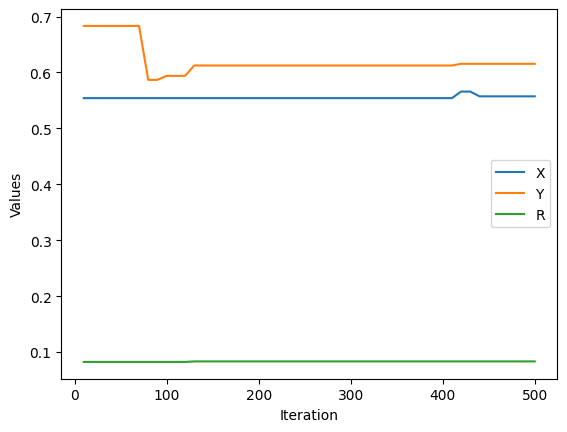

In [ ]:
import matplotlib.pyplot as plt

# Assuming u is a list of tuples with x, y, z values
u = circles_list

# Extracting x, y, z values
x_values = np.array([point[0] for point in u])
y_values = np.array([point[1] for point in u])
z_values = np.array([point[2] for point in u])


# Generating positions in the list for X-axis
positions = list(range(1, len(u) + 1))
positions = [x * 10 for x in positions]

# Plotting the line plot
plt.plot(positions, x_values, label='X')
plt.plot(positions, y_values, label='Y')
plt.plot(positions, z_values, label='R')

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Values')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
#Optimal Solution: [0.5703969581679545, 0.9, 0.3358924382356333]
#[0.4831689586021894, 0.7071439300022424, 0.2170796503421622]